In [1]:
from tensorflow import keras

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.17.1'

In [4]:
keras.__version__

'3.6.0'

In [5]:
import numpy as np
import xarray as xr
import tensorflow as tf 
# all the layers used for U-net
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from keras.models import Model
import keras.utils as ku
from keras.optimizers import Adam
import sys

In [6]:
dtrain0 = xr.open_dataset('data/nagoya_train.nc')
dval0 = xr.open_dataset('data/nagoya_val.nc')
dtest0 = xr.open_dataset('data/nagoya_test.nc')

In [7]:
# normalize data 
def datnorm(d): 
    return (d - d.mean()) / d.std() 

In [8]:
# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)
#dtrain, dval, dtest = dtrain0, dval0, dtest0

In [9]:
int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values

In [10]:
X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values

In [11]:
X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values

In [12]:

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (255, 120, 104, 1)
Shape of y_train:  (255, 120, 104)
Shape of X_validation:  (66, 120, 104, 1)
Shape of y_validation:  (66, 120, 104)
Shape of X_test:  (44, 120, 104, 1)
Shape of y_test:  (44, 120, 104)


## BUILDING U-NET HERE

In [13]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * 0.95  # Reduce learning rate by 5% after each epoch from 50 onward

lr_callback = LearningRateScheduler(scheduler)



Epoch 1: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - loss: 0.8955 - mae: 0.8047 - val_loss: 0.4821 - val_mae: 0.5888 - learning_rate: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - loss: 0.3634 - mae: 0.4977 - val_loss: 0.1486 - val_mae: 0.2968 - learning_rate: 5.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 489ms/step - loss: 0.1013 - mae: 0.2342 - val_loss: 0.0561 - val_mae: 0.1723 - learning_rate: 5.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - loss: 0.0814 - mae: 0.2174 - val_loss: 0.0750 - val_mae: 0.2118 - learning_rate: 5.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 5/300


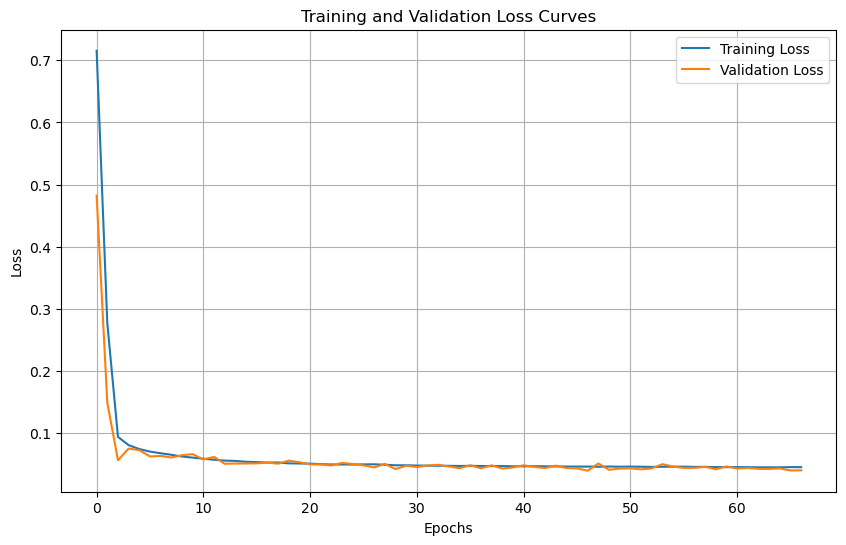

In [14]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Define the tiny U-Net model adapted for input_shape=(120, 104, 1)
def tiny_unet(input_shape=(120, 104, 1)):
    inputs = Input(shape=input_shape)
    
    # Downsampling layer 1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    # Downsampling layer 2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    
    # Upsampling layer 1
    up2 = UpSampling2D((2, 2))(conv3)
    concat2 = Concatenate()([up2, conv2])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv4 = Dropout(0.1)(conv4)
    
    # Upsampling layer 2
    up1 = UpSampling2D((2, 2))(conv4)
    concat1 = Concatenate()([up1, conv1])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)
    conv5 = Dropout(0.1)(conv5)
    
    # Output layer for continuous values (linear activation)
    outputs = Conv2D(1, (1, 1), activation=None)(conv5)
    
    return Model(inputs, outputs)

# Instantiate the tiny U-Net model with the new input shape
unet_model = tiny_unet(input_shape=(120, 104, 1))

# Compile the model with MSE loss and Adam optimizer
unet_model.compile(optimizer=Adam(learning_rate=0.00005), 
                   loss=MeanSquaredError(), 
                   metrics=['mae'])

# Define a learning rate schedule (exponential decay)
def lr_schedule(epoch, lr):
    decay_rate = 0.95  # Decay factor
    decay_epoch = 10   # Apply decay every 10 epochs
    if epoch % decay_epoch == 0 and epoch != 0:
        return lr * decay_rate
    return lr

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the model with the learning rate scheduler
history = unet_model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler]
)

# Save the model
unet_model.save('nagoya_tiny_unet_120x104.keras')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()



In [116]:
unet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 24, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 24, 32, 8) │         80 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_58    │ (None, 12, 16, 8) │          0 │ conv2d_206[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 12, 16,    │      1,168 │ max_pooling2d_58… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_59    │ (None, 6, 8, 16)  │          0 │ conv2d_207[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_208 (Conv2D) │ (None, 6, 8, 32)  │      4,640 │ max_pooling2d_59… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 12, 16,    │          0 │ conv2d_208[0][0]  │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 12, 16,    │          0 │ up_sampling2d_10… │
│ (Concatenate)       │ 48)               │            │ conv2d_207[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_209 (Conv2D) │ (None, 12, 16,    │      6,928 │ concatenate_58[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 24, 32,    │          0 │ conv2d_209[0][0]  │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_59      │ (None, 24, 32,    │          0 │ up_sampling2d_11… │
│ (Concatenate)       │ 24)               │            │ conv2d_206[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 24, 32, 8) │      1,736 │ concatenate_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 24, 32, 1) │          9 │ conv2d_210[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,685 (170.65 KB)

 Trainable params: 14,561 (56.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,124 (113.77 KB)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 13.5028 - mae: 1.2028 - val_loss: 13.1502 - val_mae: 0.8900 - learning_rate: 1.0000e-05
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 13.2648 - mae: 1.0022 - val_loss: 13.0966 - val_mae: 0.9012 - learning_rate: 1.0000e-05
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 13.1218 - mae: 0.9157 - val_loss: 13.0181 - val_mae: 0.8923 - learning_rate: 1.0000e-05
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 12.9713 - mae: 0.8255 - val_loss: 12.9409 - val_mae: 0.8940 - learning_rate: 1.0000e-05
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 12.8511 - mae: 0.7784 - val_loss: 12.8526 - val_mae: 0.8885 - learning_rate: 1.0000e-05
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 12.7488 - mae: 0.7574 - val_loss: 12.7395 - val_mae: 0.8588 - learning_rate: 1.0000e-05
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 12.6387 - mae: 0.7323 - val_loss: 12.6035 - val_mae: 0.8048

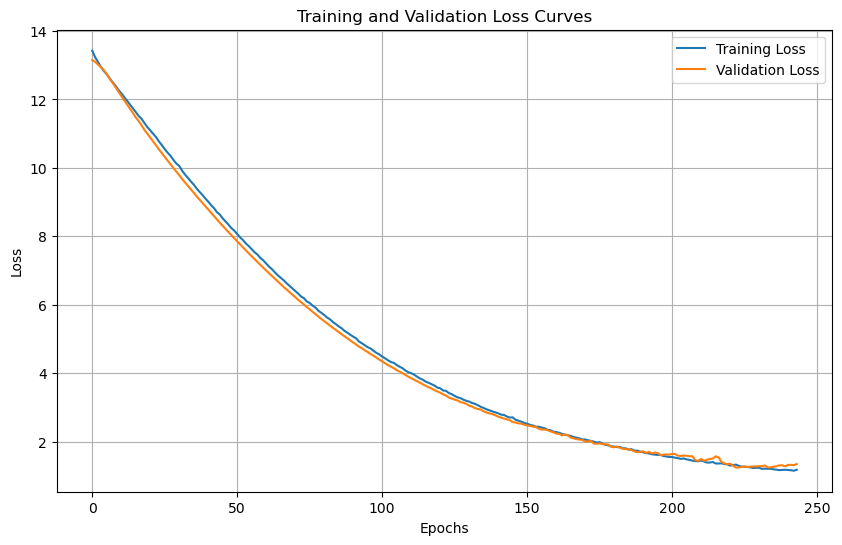

In [17]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define an enhanced U-Net model with increased capacity, batch normalization, and dropout
def enhanced_unet(input_shape=(120, 104, 1)):
    inputs = Input(shape=input_shape)
    
    # Downsampling layer 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(0.2)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    # Downsampling layer 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.2)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    # Additional downsampling layer 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(pool3)
    conv4 = BatchNormalization()(conv4)
    
    # Upsampling layer 1
    up3 = UpSampling2D((2, 2))(conv4)
    concat3 = Concatenate()([up3, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(concat3)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    # Upsampling layer 2
    up2 = UpSampling2D((2, 2))(conv5)
    concat2 = Concatenate()([up2, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(concat2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    # Upsampling layer 3
    up1 = UpSampling2D((2, 2))(conv6)
    concat1 = Concatenate()([up1, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(concat1)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    # Output layer for continuous values (linear activation)
    outputs = Conv2D(1, (1, 1), activation=None)(conv7)
    
    return Model(inputs, outputs)

# Instantiate the model with the updated input shape
unet_model = enhanced_unet(input_shape=(120, 104, 1))

# Compile the model with Huber loss and a lower learning rate
unet_model.compile(optimizer=Adam(learning_rate=1e-5), 
                   loss=Huber(delta=1.0), 
                   metrics=['mae'])

# Define callbacks: early stopping and adaptive learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Train the model
history = unet_model.fit(
    x=X_train, 
    y=y_train, 
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=16,
    callbacks=[early_stop, reduce_lr]
)

# Save the model
unet_model.save('enhanced_unet_120x104.keras')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1757e79c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
<xarray.Dataset> Size: 7MB
Dimensions:    (dat: 44, latitude: 120, longitude: 104, date: 44)
Coordinates:
  * latitude   (latitude) float32 480B 34.6 34.61 34.62 ...

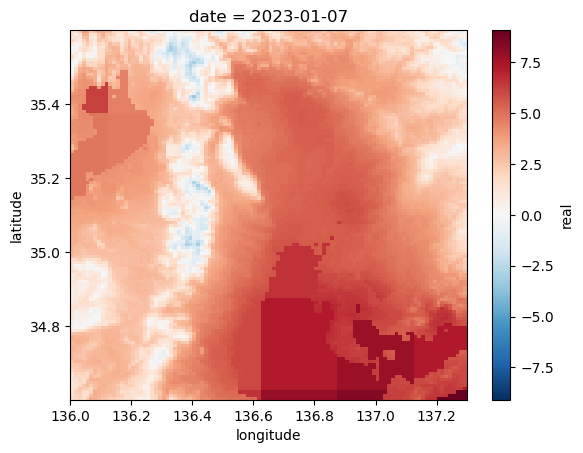

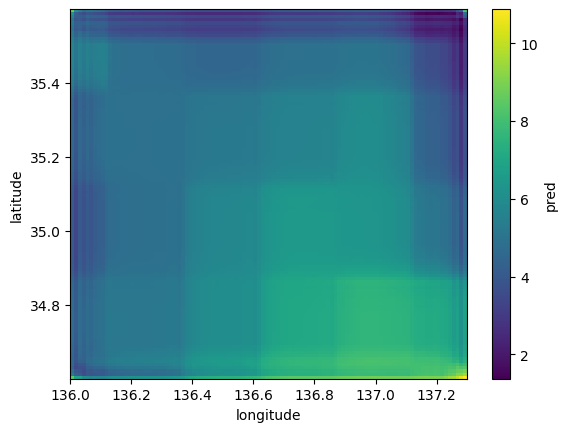

In [18]:
import os
# load model and run
xmodel = tf.keras.models.load_model('nagoya_tiny_unet_120x104.keras') 

#print(xmodel.summary())

y_pred_val = xmodel.predict(X_val, verbose=1)
y_pred_test = xmodel.predict(X_test, verbose=1) 

# return values to Kelvin 
x1, x2 = dtest0.mean()['hi'], dtest0.std()['hi']
y_pred_test_r = y_pred_test*x2.values + x1.values

x1, x2 = dval0.mean()['hi'], dval0.std()['hi']
y_pred_val_r = y_pred_val*x2.values + x1.values


do = xr.Dataset( )
do['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_test_r.squeeze())  
do.coords['latitude'] = dtest0.latitude
do.coords['longitude'] = dtest0.longitude
do['real'] = dtest0['hi']

dv = xr.Dataset( )
dv['pred'] = ( ('dat', 'latitude', 'longitude'), y_pred_val_r.squeeze())  
dv.coords['latitude'] = dval0.latitude
dv.coords['longitude'] = dval0.longitude
dv['real'] = dval0['hi']

odir = 'output/'
if not os.path.exists(odir): os.makedirs(odir)
do.to_netcdf(odir+'prediction.nc')
dv.to_netcdf(odir+'validation.nc')
do.close()
dv.close()

#do.pred[0].plot()
#plt.show()
#dtest0['hi'][0].plot()
#plt.show()
#bias = do.pred - dtest0.hi.values
#bias[0].plot()
#print(bias.mean())   

print(do)
print(dv)

do['real'][1].plot()
plt.show()
do['pred'][1].plot()